## Implement an analysis about football soccer using data analysys visualization and SQL tools



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size
thick_size=16
label_size=20


###EXPLANATION ABOUT BETTING COLUMNS AT      https://www.football-data.co.uk/notes.txt
##FROM https://www.football-data.co.uk/italym.php 
## Fetching data
#Connecting to database
path = "./"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)


In [32]:
from matplotlib import rc
rc("text", usetex=False)

In [2]:
#####Fetch all tables in sqlite database

sql_query = """SELECT * FROM sqlite_master  WHERE type='table';"""
all_tables=pd.read_sql(sql_query, conn)
all_tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [3]:
###Store some tables in separate pandas
country_data = pd.read_sql("SELECT * FROM Country;", conn)
league_data = pd.read_sql("SELECT * FROM League;", conn)
league_data["country_name"]=country_data["name"]
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team ORDER BY team_long_name;", conn)
team_stats_data=pd.read_sql("SELECT * FROM Team_Attributes;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

In [4]:
player_stats_data.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [5]:
print("The following countries are available \n")
print(list(league_data.country_name),"\n")


print("The names of the leagues are \n")
print(list(league_data.name))



The following countries are available 

['Belgium', 'England', 'France', 'Germany', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Scotland', 'Spain', 'Switzerland'] 

The names of the leagues are 

['Belgium Jupiler League', 'England Premier League', 'France Ligue 1', 'Germany 1. Bundesliga', 'Italy Serie A', 'Netherlands Eredivisie', 'Poland Ekstraklasa', 'Portugal Liga ZON Sagres', 'Scotland Premier League', 'Spain LIGA BBVA', 'Switzerland Super League']


In [6]:
###Merge player_name and player_stats tables by calling how="outer"

players_all_data=pd.merge(player_stats_data,player_data,how="outer",on=["player_api_id"])
players_all_data["Date"]=pd.to_datetime(players_all_data.date)
players_all_data["year"]=players_all_data["Date"].apply(lambda x: x.year)

##Check that merging works with this example!!!
#df1=player_data.sort_values("player_api_id")[["player_api_id","player_name","height"]][:]
#print(df1)
#df2=player_stats_data.sort_values("player_api_id")[["player_api_id","overall_rating","date","potential","crossing"]][:]
#print(df2)
#dftot=pd.merge(df1,df2,how="outer",on=["player_api_id"])
#dftot["Date"]=pd.to_datetime(dftot.date)
#dftot["year"]=dftot["Date"].apply(lambda x: x.year)
#----------


In [7]:
df=players_all_data.sort_values("year")
#df_yearly=players_all_data.sort_values("year").set_index(["year","player_name"])
df_yearly_avg=df.groupby(["year","player_name"]).mean()
#df_yearly_avg.loc[(2015,)].sort_values("overall_rating",ascending=False).head(4)

#df_yearly_avg.loc[(2015,"Lionel Messi")]
#df_yearly_avg.sort_values("overall_rating",ascending=False)
#df_yearly_avg.xs(2016).sort_values("overall_rating",ascending=False).head(5)

In [8]:
###Top 10 player by averaging over all columns 
df.groupby("player_name").mean().sort_values("overall_rating",ascending=False)[["overall_rating"]].head(10)

,overall_rating
player_name,
Lionel Messi,92.192308
Cristiano Ronaldo,91.280000
Franck Ribery,88.458333
Andres Iniesta,88.320000
Zlatan Ibrahimovic,88.285714
Arjen Robben,87.840000
Xavi Hernandez,87.636364
Wayne Rooney,87.222222
Iker Casillas,86.954545


In [9]:
np.mean(df_yearly_avg.xs("Lionel Messi",level=1).overall_rating)


91.36243386243386

In [10]:
####Figure out the best players of all time
###Average overall_rating over time for each player and pick the best 10 players 

best_list=[]
for yr in df.year.unique():
    top5=df_yearly_avg.xs(yr).sort_values("overall_rating",ascending=False)
    dict_out={}
    for player in list(top5.index):
        #print(player)
        dict_out={"player_name":player,"overall_rating": top5.loc[player].overall_rating}
        best_list.append(dict_out)
        

    
    
best_df=pd.DataFrame(best_list)
best_df=best_df.groupby("player_name").mean()
best_df=best_df.sort_values("overall_rating",ascending=False)
print("The top 10 players of all time")
print(best_df.head(10))

print("\n However this method is unfair for older players as their overall skills decrease over time and  \n")
print("reducing their average overall_rating")

The top 10 players of all time
                    overall_rating
player_name                       
Lionel Messi             91.362434
Cristiano Ronaldo        90.844444
Zlatan Ibrahimovic       88.083333
Franck Ribery            87.825000
Wayne Rooney             87.655000
Andres Iniesta           87.638889
Xavi Hernandez           87.627778
Iker Casillas            87.530000
Arjen Robben             87.520000
Gianluigi Buffon         86.654167

 However this method is unfair for older players as their overall skills decrease over time and  

reducing their average overall_rating


In [11]:
###Top 10 rating regardless of year and just taking the maximum overall rating 
players_all_data.groupby("player_name")[["overall_rating","stamina"]].max().sort_values("overall_rating",ascending=False).head(10)
                                                    

,overall_rating,stamina
player_name,,
Lionel Messi,94.0,83.0
Wayne Rooney,93.0,92.0
Gianluigi Buffon,93.0,56.0
Cristiano Ronaldo,93.0,91.0
Xavi Hernandez,92.0,87.0
Gregory Coupet,92.0,72.0
Ronaldinho,91.0,80.0
Iker Casillas,91.0,62.0
John Terry,91.0,87.0


Index(['id_x', 'player_fifa_api_id_x', 'player_api_id', 'date',
       'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'id_y', 'player_name', 'player_fifa_api_id_y',
       'birthday', 'height', 'weight', 'Date', 'year'],
      dtype='object')


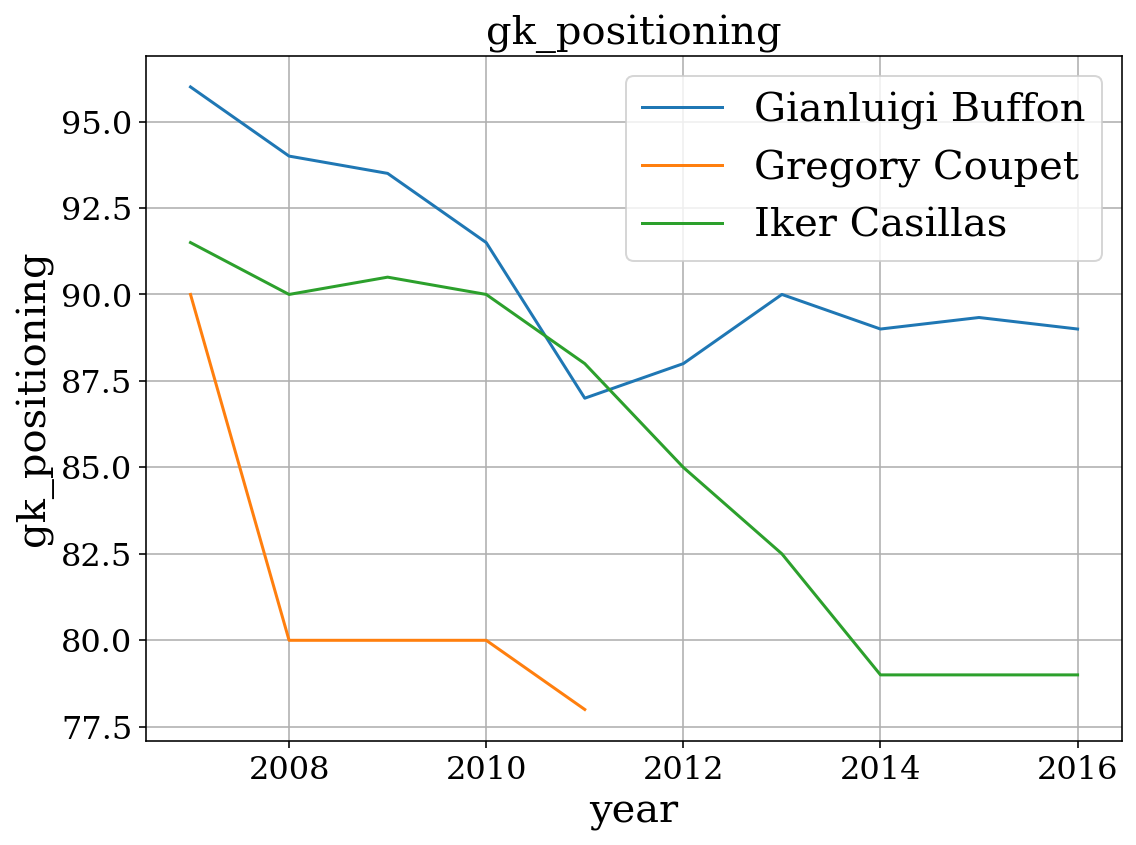

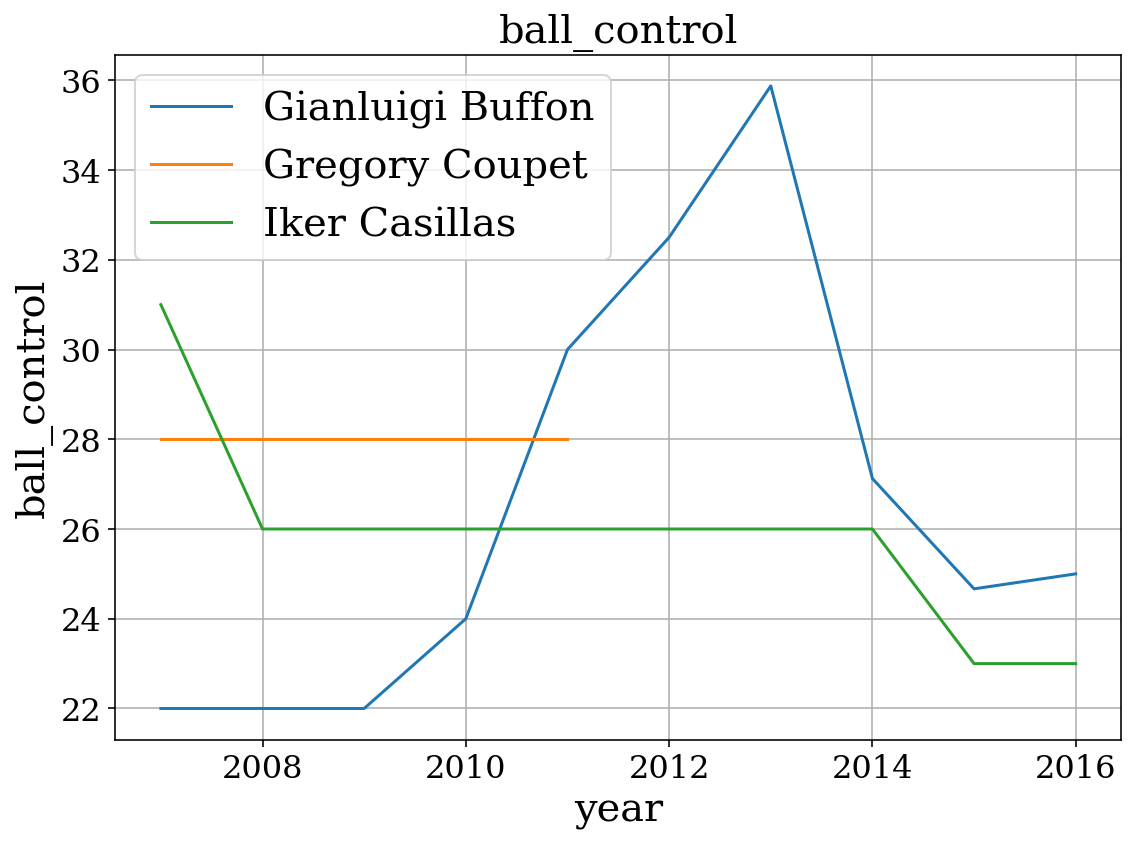

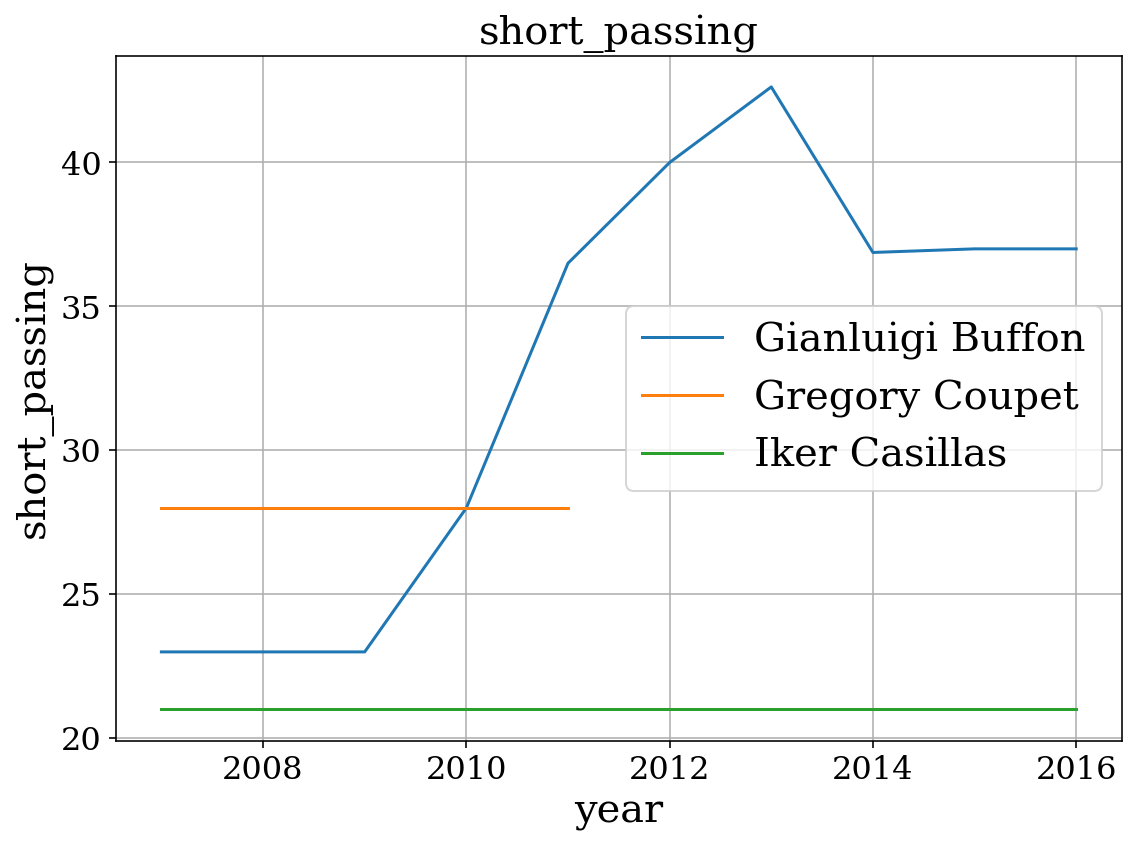

In [37]:
df=players_all_data.sort_values("year")
print(df.columns)


def plot_fun1(my_player_list,ability):
    for playerstr in my_player_list:     
        dfout=df[df.player_name==playerstr]
        dfout=dfout.groupby("year").mean()
        plt.plot(dfout.index,dfout[ability],label=playerstr)
        plt.xlabel("year",size=label_size)
        plt.ylabel(ability,size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.legend(loc="best",prop={'size': label_size})
        plt.title(ability,size=20)
        plt.grid(True)
        plt.tight_layout()
        #plt.savefig('LISA_SCANS_1/geometrical_2.pdf', dpi=300)
    plt.show()

my_player_list=["Gianluigi Buffon","Gregory Coupet","Iker Casillas"]
ability="gk_positioning"
plot_fun1(my_player_list,ability)    

ability="ball_control"
plot_fun1(my_player_list,ability)    

ability="short_passing"
plot_fun1(my_player_list,ability)    



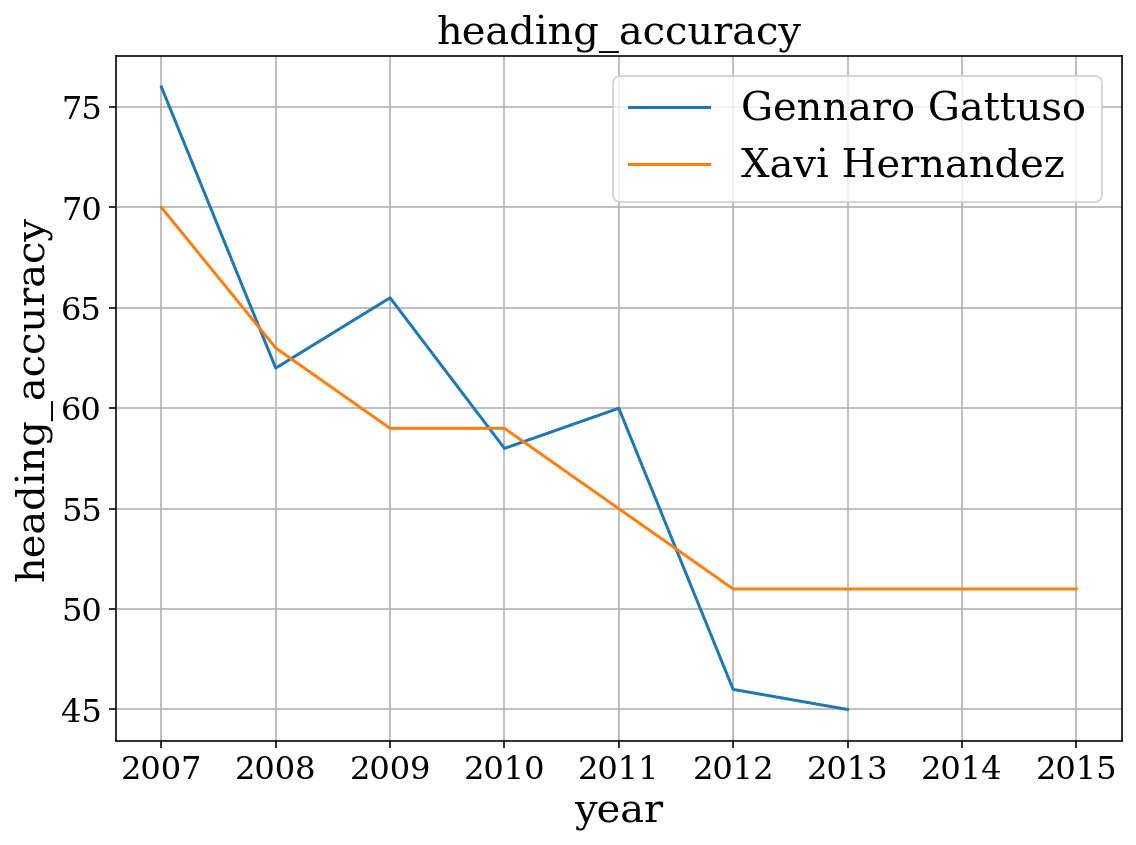

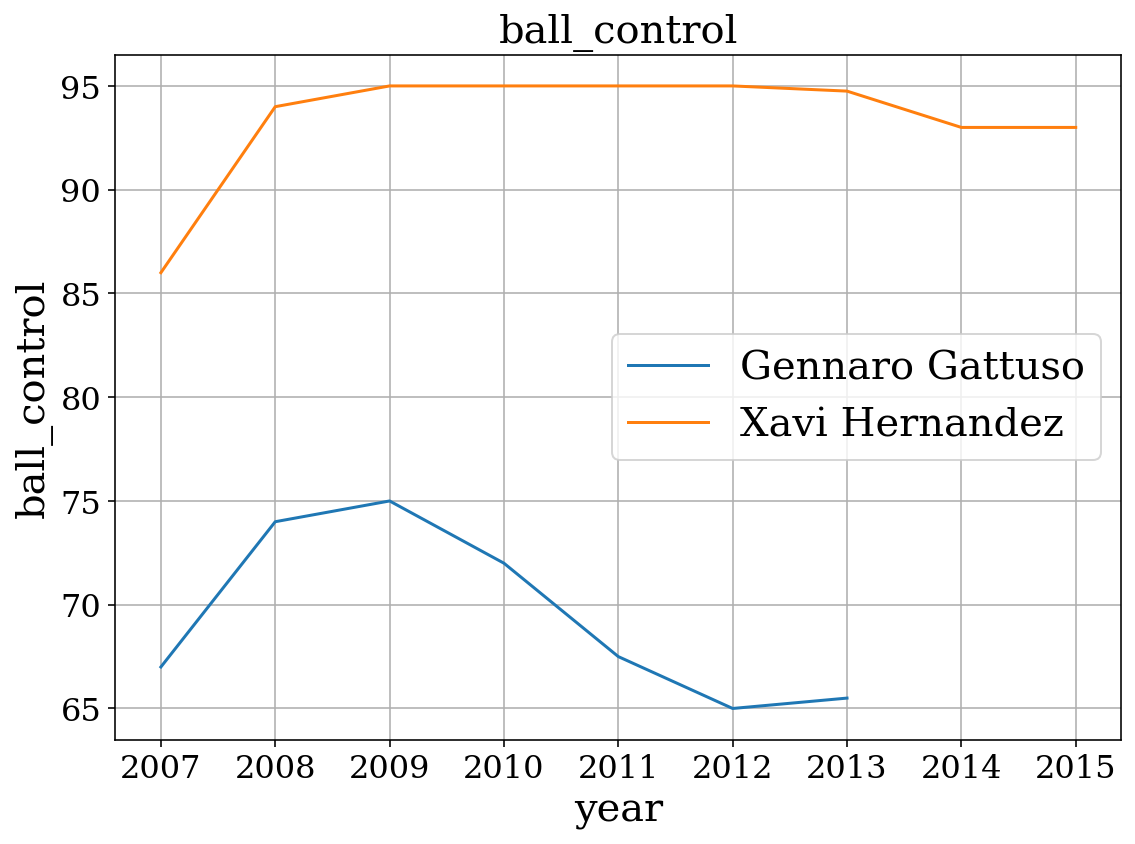

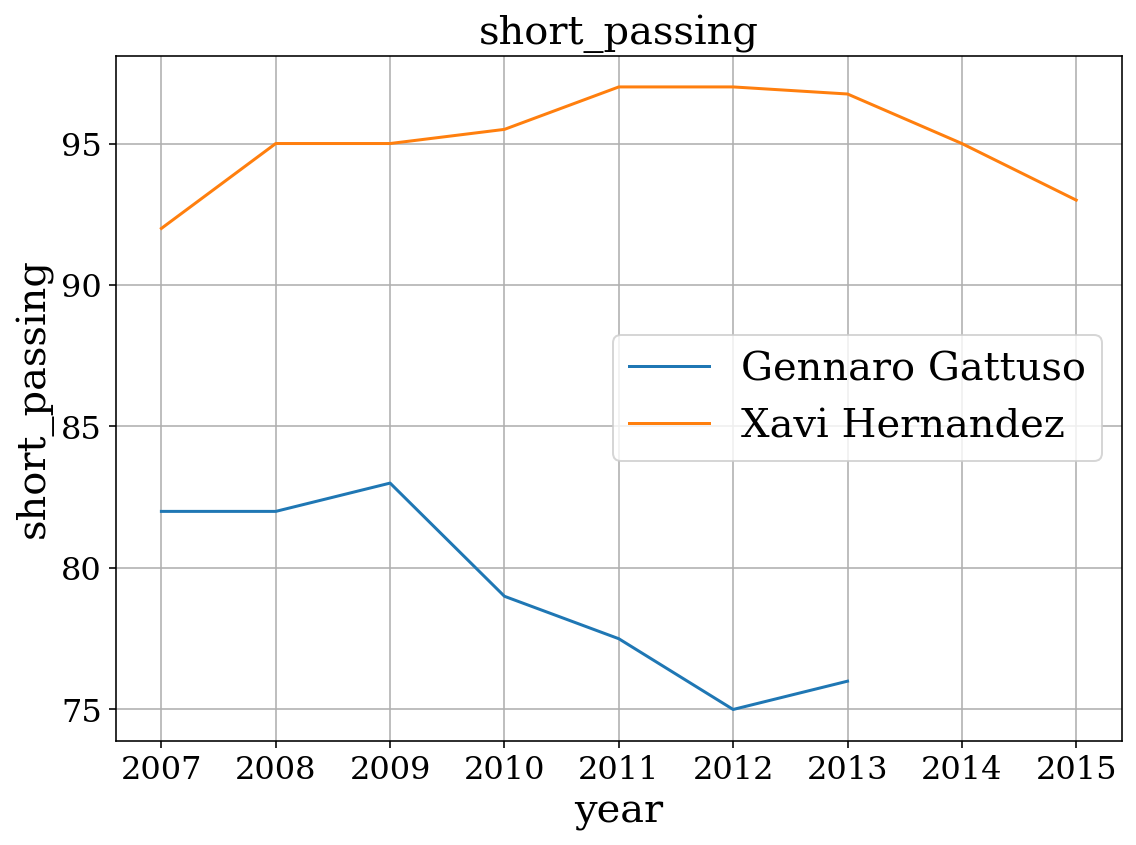

In [39]:
#my_player_list=["Gianluigi Buffon","Gregory Coupet","Iker Casillas"]
my_player_list=["Gennaro Gattuso","Xavi Hernandez"]
ability="heading_accuracy"



plot_fun1(my_player_list,ability)    

ability="ball_control"
plot_fun1(my_player_list,ability) 


ability="short_passing"
plot_fun1(my_player_list,ability) 

## Arrange Data into Features Matrix

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

In [41]:
df=players_all_data.sort_values("year")
year=2015
df=df[df.year==year]

all_features = ['overall_rating', 'potential','crossing', 'finishing', 'heading_accuracy',
            'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
            'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
            'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
            'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
            'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
            'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
            'gk_reflexes','height', 'weight']

features = ['crossing', 'finishing', 'heading_accuracy',
            'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
            'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
            'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
            'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
            'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
            'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
            'gk_reflexes','height', 'weight']



# Apply Standardization to features matrix X
x = df.loc[:, features].dropna().values

x = StandardScaler().fit_transform(x)



## KMeans Clustering


In [42]:
# Make an instance of KMeans with 3 clusters
kmeans = KMeans(n_clusters=4, random_state=1)

# Fit only on a features matrix
kmeans.fit(x)

KMeans(n_clusters=4, random_state=1)

In [43]:
# Get labels and cluster centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
x = pd.DataFrame(x, columns = features)


In [44]:
kmeans.inertia_

463339.02356926084

## Visually Evaluate the Clusters


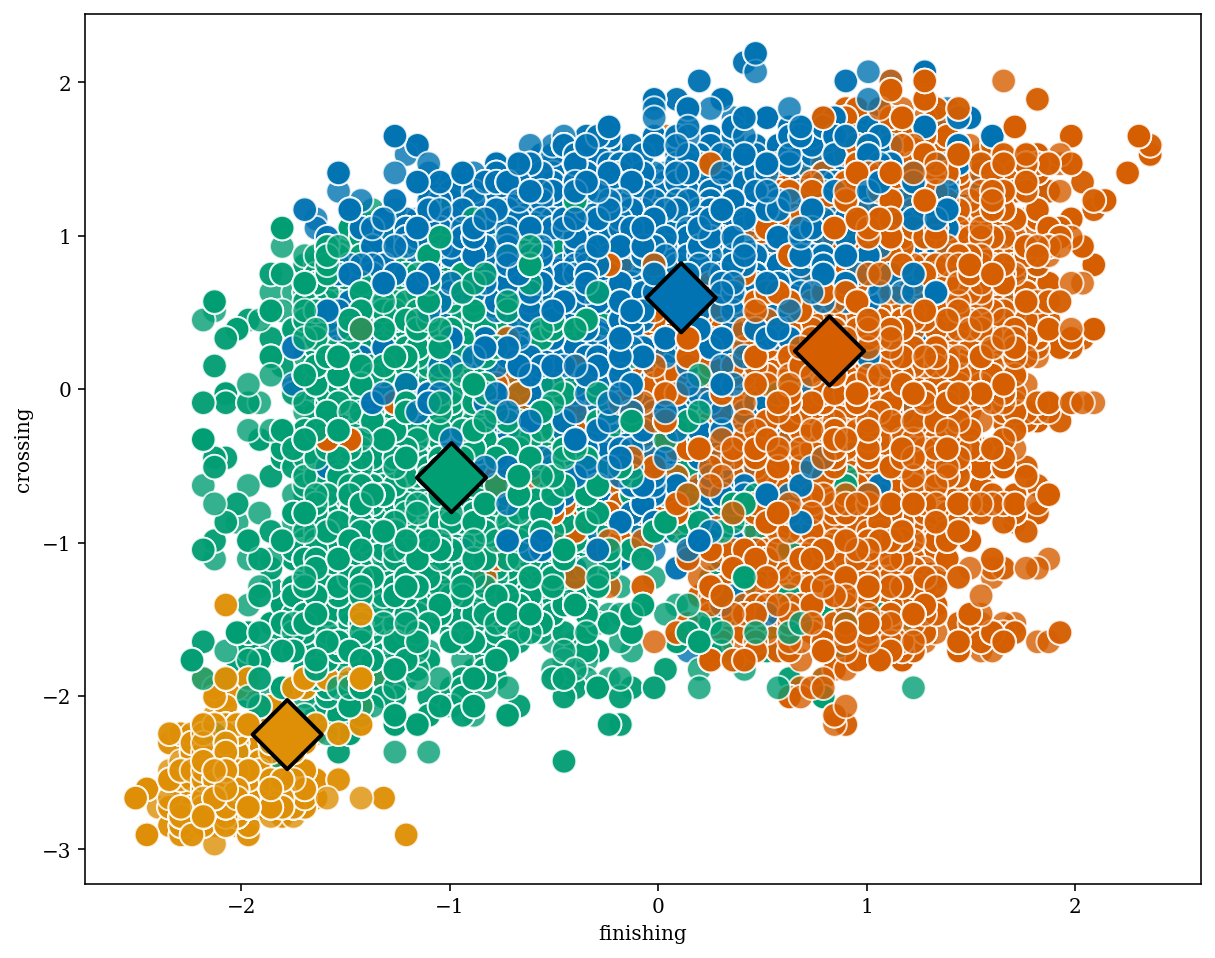

In [54]:

features = ['crossing', 'finishing', 'heading_accuracy',
            'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
            'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
            'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
            'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
            'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
            'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
            'gk_reflexes','height', 'weight']

cluster_centers = pd.DataFrame(centroids, columns = features)


# Set the figure size
plt.figure(figsize=(10, 8))
xdat='finishing'
ydat='crossing'

#Plot the Clusters
ax = sns.scatterplot(data = x,
                     x = xdat,
                     y = ydat, 
                     hue =labels, 
                     palette = 'colorblind', 
                     alpha = 0.8, 
                     s = 150,
                     legend = False)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers, 
                     x = xdat,
                     y = ydat, 
                     hue = cluster_centers.index, 
                     palette = 'colorblind', 
                     s = 600,
                     marker = 'D',
                     ec = 'black', 
                     legend = False
                    )

In [55]:
cluster_centers.index

RangeIndex(start=0, stop=4, step=1)

## Count the number of each cluster

In [52]:
pd.Series(labels).value_counts()

3    12191
0    10104
2     7395
1     2128
dtype: int64

In [80]:
df=players_all_data.sort_values("year")
df=df[df.year==year]
features = ["player_name","overall_rating",'finishing', "stamina",'gk_reflexes']

df=df[features].dropna()
df["position"]=list(labels)
df=df.sort_values("overall_rating",ascending=False)

midfield, striker,defense, goali=0,3,2,1

df[df.position==midfield].groupby(["player_name","position"]).mean().sort_values("overall_rating",ascending=False).iloc[:20]

#df[df.player_name=="Ashley Young"]

#df[df.player_name=="Ashley Young"]

,,overall_rating,finishing,stamina,gk_reflexes
player_name,position,,,,
Andres Iniesta,0,88.000000,73.000000,64.000000,7.0
Bastian Schweinsteiger,0,87.333333,76.000000,82.666667,11.0
Thiago Silva,0,87.000000,38.000000,78.500000,10.0
Sergio Ramos,0,87.000000,60.000000,83.500000,11.0
Luka Modric,0,87.000000,71.000000,86.333333,9.0
Philipp Lahm,0,87.000000,47.000000,85.200000,5.0
Gareth Bale,0,87.000000,81.000000,89.875000,6.0
Jerome Boateng,0,86.714286,34.000000,73.857143,5.0
Toni Kroos,0,86.200000,76.000000,76.000000,10.0


In [23]:
## Select country and display all available seasons
country_name="Italy"
team_name="Juventus"
league_name=None
season_name=None



In [24]:
if myinput in [country_title,team_name,league_name,season_name]:
    print("We chosed:",myinput)

country_id=country_data[country_data["name"]==country_title].id
serie_A_matches=match_data[match_data.country_id==int(country_id)]

all_season=list(serie_A_matches.season.unique())
print("Seasons available are \n",all_season)




NameError: name 'myinput' is not defined

In [ ]:
if myinput in [country_title,team_name,league_name,season_name]:
    print("We chosed:",myinput)

country_id=country_data[country_data["name"]==country_title].id
serie_A_matches=match_data[match_data.country_id==int(country_id)]

all_season=list(serie_A_matches.season.unique())
print("Seasons available are \n",all_season)




In [ ]:
#(serie_A_matches.columns).intersection((team_data.columns))

In [ ]:
###Pick one season and select one team
serie_A_matches=serie_A_matches[serie_A_matches.season==all_season[-1]]
print("total number of matches in the whole season", len(serie_A_matches))
###Select all the team's matches and season 
team_number=int(team_data[team_data.team_long_name=="Milan"].team_api_id)
team_matches=serie_A_matches[(serie_A_matches.home_team_api_id==team_number) | (serie_A_matches.away_team_api_id==team_number)]
print("each team plays a total of ",len(team_matches)," games")
print("Total number of teams ",len(serie_A_matches.home_team_api_id.unique()))

seriea_A_teams=team_data[team_data["team_api_id"].isin(list(serie_A_matches.home_team_api_id.unique())) ]


In [ ]:
seriea_A_teams

In [ ]:
match_data.B365H

In [ ]:
list(match_data.columns)

In [ ]:
Milan_Statistics = pd.read_sql("""SELECT *
 
                                        FROM Team 

                                        left join Team_Attributes
                                        
                                        on Team_Attributes.team_api_id = Team.team_api_id
                                        
                                        where team_long_name= "Milan"
                                        
                        
                        """, conn)

In [ ]:
Milan_Statistics.date